## Determinando la edad y el sexo de una persona segun la radiografia de su mano

### David Calderon Ceja
### Keshava Tonathiu Sanchez Barbosa

#### El objetivo de este proyecto es crear un modelo de redes nueronales el cual sea capaz de brindar una predicción de edad estimada y el sexo de la persona segun la radiografía de su mano

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai as fai
import fastai.vision as fv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import numpy as np
import random
import gc
from torch.utils.data import Dataset
from torchvision import transforms, utils
import PIL
from pathlib import Path

### Estado del dataset obtenido:

#### El dataset con el que se trabajo fue obtenido de kaggle: https://www.kaggle.com/kmader/rsna-bone-age
#### El contenido son dos carpetas (train, test) conteniendo las imagenes para procesar con la red neuronal, acompañando cada carpeta son un csv con la información de la radiografía, la edad en meses y el sexo de la persona

In [3]:
#!ls

In [4]:
testP = Path("boneage-test-dataset/boneage-test-dataset/")

In [5]:
#!ls {testP}

In [6]:
trainP = Path("boneage-training-dataset/boneage-training-dataset/")
#!ls {trainP}

### Pre-procesamiento de datos, creando la funcion para generar etiquetas

In [7]:
with open("boneage-training-dataset.csv", 'r') as F:
    T = F.readlines()
    dic = {}
    for image in range(len(T)):
        if image != 0:
            st = T[image].split(',')
            if st[2] == "True\n":
                st[2] = "1" #es hombre
            elif st[2] == "False\n":
                st[2] = "0" #es mujer
            dic[st[0]] = (st[1], st[2])
#print(dic)

In [8]:
def hueso_edad(image):
    imgs = image.stem.split("/")
    img = imgs[-1]
    img = img.replace(".png", "")
    tar = dic[img]
    return(float(tar[0]), float(tar[1]))

In [9]:
class ObjetoHuesoEdadSexo(fai.basics.ItemBase):
    def __init__(self,array): 
        self.data = np.array(array).astype(np.float32)

    def __str__(self): 
        L = ["Hombre", "Mujer"]
        return str(self.data[0]) + " / " +  L[int(self.data[1] > 0.5)]

def es_lista(x): 
    return isinstance(x, (list,tuple))
    
class ListaHuesoEdadSexo(fai.basics.ItemList):
    def __init__(self, items:fai.basics.Iterator, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        

        self.c = items.shape[1]

    def get(self, i):
        o = super().get(i)
        return ObjetoHuesoEdadSexo(o)

    def reconstruct(self,t):
        if es_lista(t):
            return ObjetoHuesoEdadSexo(np.array(t))
        return ObjetoHuesoEdadSexo(t.numpy())

### Data augmentation:

#### En nuestro proyecto estamos trabajando con manos de personas, por lo cual warp esta desactivado, para evitar que deforme las manos de las personas. De la misma manera para evitar que se pierdan partes de la mano desactivamos el zoom, y para evitar que se deteriore la calidad de la imagen quitamos max lighting.

#### Por otro lado, tenemos max_rotate en 360 grados ya que una mano en cualquier angulo sigue siendo una mano.

In [10]:
def load_data(folder, img_size, batch_size):
    tfms = fv.get_transforms(max_warp = 0.0, max_zoom = 1, max_lighting = 0.0, max_rotate = 360) #warp = 0 para evitar que
                                                            #se deforme demasiado la imagen
    return (fv.ImageList.from_folder(folder)
           .split_by_rand_pct(0.2, seed = 3)
           .label_from_func(hueso_edad, label_cls = ListaHuesoEdadSexo)
           .transform(tfms, size = img_size)
           .databunch(bs = batch_size))

#### Cargamos las imagenes, con resolución de 256 y un batch size de 128

In [11]:
data = load_data(trainP, 256, 128)

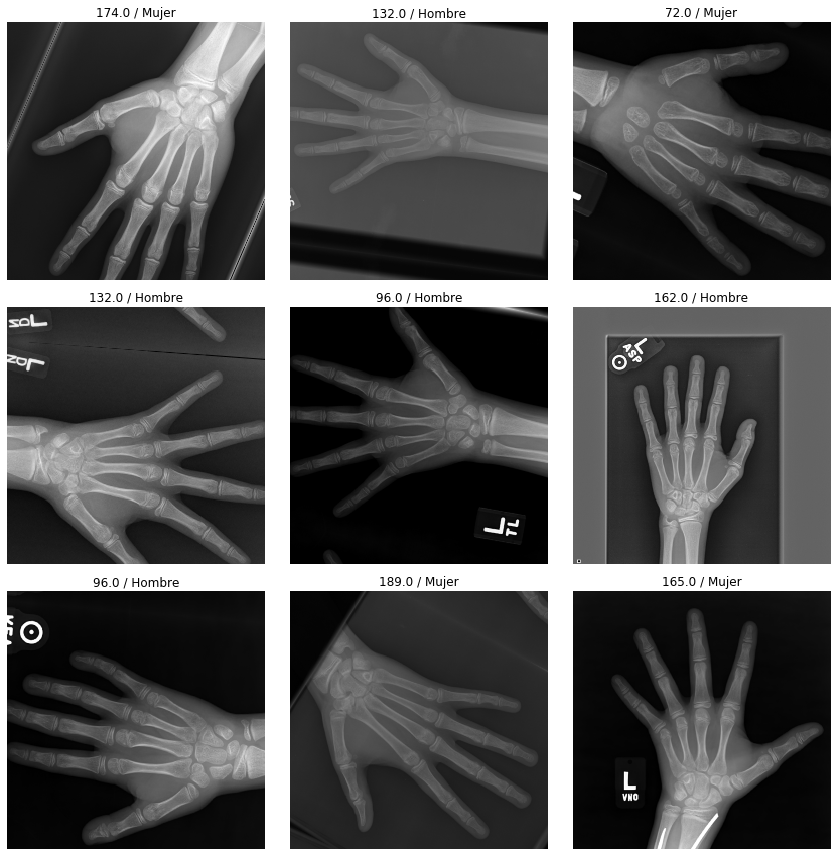

In [12]:
data.show_batch(rows = 3)

In [13]:
import pandas as pd

bone_train = pd.read_csv('boneage-training-dataset.csv')
bone_test = pd.read_csv('boneage-test-dataset.csv')

In [14]:
bone_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12610 entries, 0 to 12609
Data columns (total 3 columns):
id         12610 non-null int64
boneage    12610 non-null int64
male       12610 non-null bool
dtypes: bool(1), int64(2)
memory usage: 209.5 KB


In [15]:
bone_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
Case ID    200 non-null int64
Sex        200 non-null object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


#### Como un objetivo principal es predecir la edad de la persona, entonces necesitamos conocer cual es el valor maximo de edad presente en el conjunto de datos, para saber cual es el maximo valor posible que debe poder asignar el modelo

In [16]:
bone_train['boneage'].max()

228

In [17]:
bone_train.min()

id         1377.0
boneage       1.0
male          0.0
dtype: float64

### Modelo:

#### El modelo paso por multiples iteraciones, primero como activador hicimos pruebas entre ReLu, LeakyReLU y CELU.
#### Por otro lado para evitar que el modelo se fijara sobre valores "seguros" cerca de la media de la edad decidimos utilizar dropout, para evitar que se overfiteara el modelo.
#### Ademas de esto nuestro modelo tuvo distintos acomodos de las capas los cuales tenian distintas repercuciones en los resultados:
- ReLU, BatchNorm1d, Dropout, Linear: Esta fue la primer iteración del modelo donde obteniamos una perdida para el resultado de la predicción del sexo de 0.70 y de edad de 0.25
- BatchNorm1d, LeakyReLU, Dropout, Linear: La segunda iteración del modelo donde logramos recortar a 0.17 la perdida de la predicción de edad, sin embargo la perdida de sexo se mantuvo en 0.69
- BatchNorm1d, CELU(0.075, inplace = TRUE), Dropout, Linear: Nuestro tercer modelo se mantiene estancado en 0.69 la perdida de sexo, pero la edad baja a 0.14 de perdida
- CELU(0.15, inplace = TRUE), BatchNorm1d, Dropout, Linear: El modelo final, nos brinda una pequeña mejora en la perdida de edad con 0.12, sin embargo mostro una gran mejora en la perdida de la edad logrando reducirla hasta 0.59

In [18]:
class ageSexModel(nn.Module):
    def __init__(self, filters, p = 0.33):
        super().__init__()
        ni = filters[0]
        layers = list(fv.models.resnet34(pretrained=True).children())[:-2]
        layers += [fv.AdaptiveConcatPool2d(), fv.Flatten()]
        
        for ni,no in zip(filters[:-1], filters[1:]):
            layers += [nn.CELU(0.15, inplace = True),
                       nn.BatchNorm1d(ni),
                        #nn.LeakyReLU(),
                       nn.Dropout(p),
                       nn.Linear(ni,no)]
            
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        z = torch.sigmoid(self.net(x))
        agePred = z[:, 0].unsqueeze(0)*229 #se multiplica por 229 porque la edad maxima es 228
        sexPred = z[:, 1].unsqueeze(0)
        return torch.cat([agePred,sexPred]).transpose(1,0)

In [19]:
def ageLoss(pred, targ):
    a = 0.3
    p = (1 + pred[:, 0])**a
    t = (1 + targ[:, 0])**a
    age_loss = torch.nn.functional.l1_loss(p, t)
    return age_loss

def sexLoss(pred, targ):
    sex_loss = bce_loss(pred[:, 1], targ[:, 1])
    return sex_loss

### Funciones de perdida

#### Basadas en las funciones de perdida usadas en clase para predecir sexo y edad, balancear los pesos de la perdida de sexo y edad se mostro bastante dificil, algunos de los comportamientos segun los pesos asignados:

- age_loss con cualquier peso menor que 1 resultaba en el modelo estancandose por completo en la media, prediciendo solo valores al rededor de 142
- sex_loss mayor a 1.5 resultaba con sex_loss estancado en 0.70 y ademas de esto estancando age_loss en valores al rededor de 135
- La combinación perfecta: 1 y 1.3, estos pesos nos resultaron los mas convenientes para el modelo, ya que nos permitia desestancar sex_loss y bajarlo a 0.59 y no era tan importante la diferencia de peso asi que no atontaba age_loss, permitiendolo hacer predicciones mucho mas precisas y cercanas a los valores reales

In [20]:
bce_loss = torch.nn.BCEWithLogitsLoss() #torch.nn.BCELoss() #BCEloss es bastante util para para penalizar errores en predicciones de sexo
def ageSexLoss(pred, targ):
    a = 0.3
    p = (1 + pred[:, 0])**a
    t = (1 + targ[:, 0])**a
    age_loss = torch.nn.functional.l1_loss(p, t)
    sex_loss = bce_loss(pred[:, 1], targ[:, 1])
    return age_loss + sex_loss*1.3 #Sumamos ambas perdidas, para que se penalize correctamente al modelo

In [21]:
torch.cuda.empty_cache()

import gc

gc.collect()

19075

In [22]:
model = ageSexModel([1024, 512, 256, 128, 64, 32, 16, 2])

In [23]:
learn = fv.Learner(data, model, wd = 0.1, loss_func = ageSexLoss)

In [24]:
learn.metrics += [ageLoss, sexLoss]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


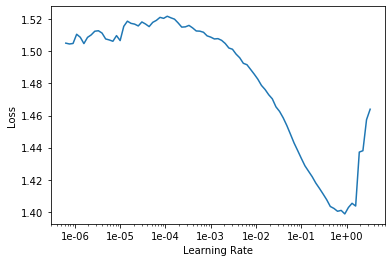

In [25]:
learn.lr_find(); learn.recorder.plot()

In [26]:
learn.fit_one_cycle(15, max_lr = 2e-3)

epoch,train_loss,valid_loss,ageLoss,sexLoss,time
0,1.470352,1.264818,0.332853,0.716896,03:04
1,1.374129,1.258958,0.334284,0.711287,03:05
2,1.270507,1.192317,0.274316,0.706154,03:08
3,1.186935,1.241075,0.334937,0.697029,03:05
4,1.130180,1.139617,0.242824,0.689841,03:11
5,1.101018,1.083966,0.194353,0.684317,03:05
6,1.087735,1.292294,0.374559,0.705950,03:04
7,1.086501,1.105714,0.197076,0.698952,03:07
8,1.076933,1.165753,0.268506,0.690189,03:15
9,1.060766,1.269568,0.375900,0.687437,03:06


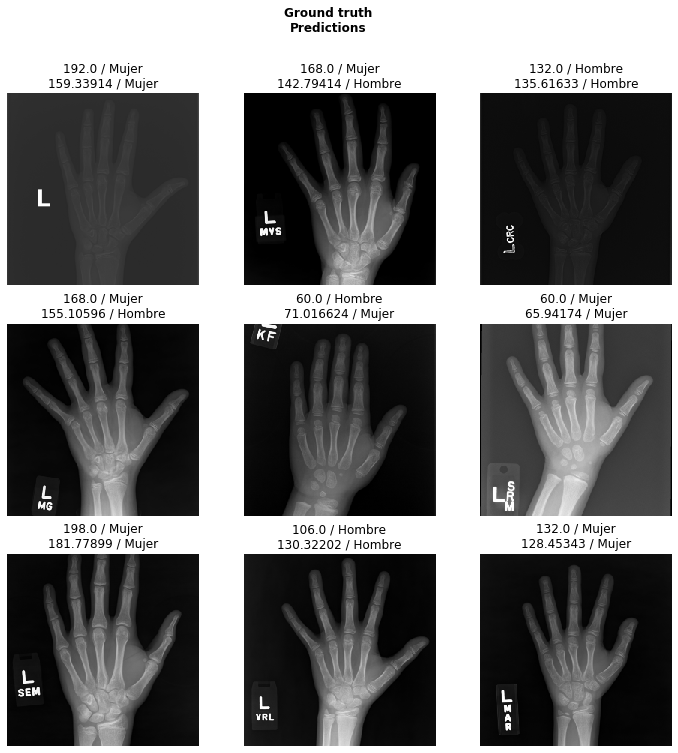

In [27]:
learn.show_results(rows = 3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


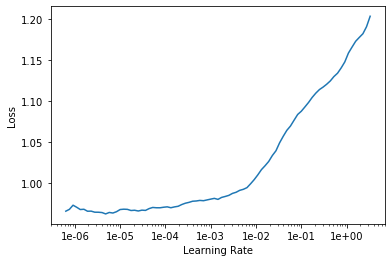

In [28]:
learn.lr_find(); learn.recorder.plot()

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(5, max_lr = 1e-6)

epoch,train_loss,valid_loss,ageLoss,sexLoss,time
0,0.973128,0.912174,0.134365,0.598315,03:45
1,0.973203,0.912281,0.133826,0.598811,03:15
2,0.977725,0.910176,0.132364,0.598317,03:27
3,0.974653,0.908382,0.130830,0.598117,03:15
4,0.972275,0.906744,0.128991,0.598271,03:10


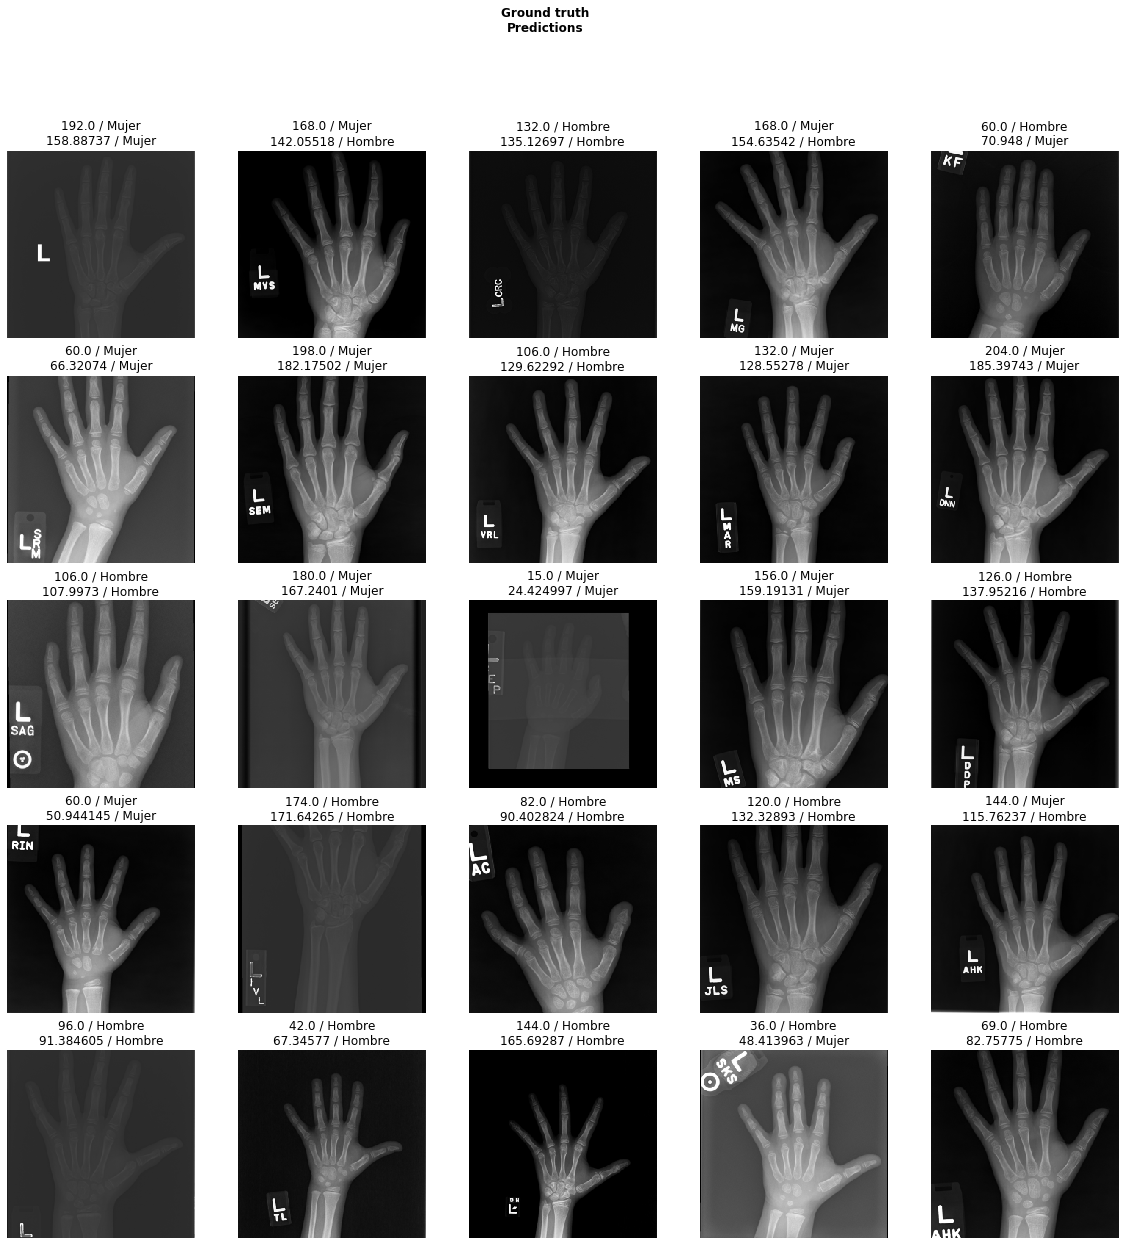

In [32]:
learn.show_results(rows = 5)